In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [1]:
%cd ..
from src.manifolds.landmarks import *
M = landmarks(2)
print(M)

/home/line/Dropbox/theanogeometry
2 landmarks in R^2 (dim 4). kernel Gaussian, k_alpha=1, k_sigma=[[ 0.5  0. ]
 [ 0.   0.5]]


In [2]:
# Riemannian structure
from src.Riemannian import metric
truncate_high_order_derivatives = False
metric.initialize(M)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [3]:
from src.plotting import *
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 7

In [4]:
from src.statistics.Regression.params import *

# initialize
M.N.set_value(2)
n_steps.set_value(100)

n_samples.set_value(20)
mx.set_value(1)

# Obs: takes time to load
from src.framebundle import FM
from src.stochastics import stochastic_development
FM.initialize(M)
stochastic_development.initialize(M)

from src.statistics.Regression import Processes
Processes.initialize(M)

from scipy import io
A=io.loadmat('/home/line/Desktop/Regressiongpu/Regression/ipmi-data/matlab.mat')

1


In [5]:
# Regression dynamics
from src.statistics.Regression import MM
MM.initialize(M)

1
1
1
1


In [6]:
M.N.set_value(1)
mx.set_value(1)
n_samples.set_value(50)

# True Parameters:
y0 = np.array([-1,0,0,0,1,0]).reshape((3,2))[0:M.N.eval(),:].flatten()
W0 = np.array([[2,0.1],[0.1,2]])[0:mx.eval(),0:mx.eval()]
drift0 = np.array([1,2])[0:mx.eval()]
tau0 = 0.5
ui0 = np.array([[0,1],[1,0],[0,1],[1,0],[0,1],[1,0]])[0:M.dim.eval(),0:mx.eval()]
para0 = np.hstack((tau0,drift0,W0.flatten(),y0,ui0.flatten()))

q0 = np.hstack([y0.flatten(),ui0.flatten()]).astype(theano.config.floatX)
print("q0 = ", q0)

x00 = np.array([0,0])[0:mx.eval()]
xT0 = np.random.normal(0, 6, (n_samples.get_value(),mx.eval()))

q0 =  [-1.  0.  0.  1.]


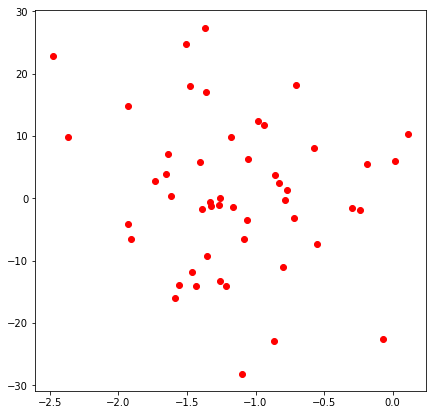

In [7]:
# test processes:
yT = np.zeros((n_samples.get_value(),M.dim.eval()))
for i in range(n_samples.get_value()):
    dwt0 = np.random.normal(0, np.sqrt(dt.eval()), (n_steps.get_value(),mx.get_value()))
    Xt = M.BrownBridgef(dwt0.flatten(),x00,xT0[i,:])
    Zt = M.RegProcf(Xt.flatten(),x00,W0,drift0)
    Ut = M.stochastic_developmentf(q0,Zt[1])[1]

    #plotFMx(Ut,N_vec=0)
    yT[i,:] = Ut[-1,0:M.dim.eval()] + np.random.normal(0, tau0, (1,M.dim.eval()))
    plt.plot(yT[i,0], yT[i,1], 'ro')

# Method of Moments

In [8]:
rs = np.random.RandomState(1234)
rng = theano.tensor.shared_randomstreams.RandomStreams(rs.randint(999999))

xt = T.vector()
para = T.vector()
x0 = T.vector()
dwt = T.vector()

M.Predif = theano.function([xt,dwt,x0,para], M.Predi(xt,dwt,x0,para))

def Pred(para,xT,x0,y):
    
    tau = para[0]
    dwt = rng.normal(size = (n_samples.get_value(),n_steps.get_value(),mx.get_value()), avg = 0, std = T.sqrt(dt.eval()))
    (cout, updates) = theano.scan(fn=M.Predi,
                                  sequences=[xT,dwt],
                                  non_sequences=[x0,para],
                                  n_steps=n_samples.get_value())
    
    M1 = 1./2*T.mean(y - cout, axis = 0)**2
    M2 = 1./2*(1./n_samples.get_value()*T.dot(xT.T,(y-cout)).flatten())**2
    #M2 = 1./2*T.mean(xT.reshape((n_samples,m))*(y - cout), axis = 0)**2
    M3 = 1./2*(1./(y.shape[0]-2)*T.sum((y - cout)**2, axis = 0) - tau**2)**2
    
    return 1./M1.shape[0]*T.sum(M1) + 1./M2.shape[0]*T.sum(M2) + 1./M3.shape[0]*T.sum(M3)

#para = T.vector()
y = T.matrix()
x0 = T.vector()
xT = T.matrix()
Predf = theano.function([para,xT,x0,y], Pred(para,xT,x0,y),
                       on_unused_input='ignore')

#gradP = lambda para,xT,x0,y: T.grad(Pred(para,xT,x0,y),para)
#gradPf = theano.function([para,xT,x0,y], gradP(para,xT,x0,y))

#n_sim = theano.shared(20)
#def fopt(para,y,x0,xT,pred0,b):
#    
#    n_sim1 = ifelse(T.eq(b,0), 10, n_sim)
#    
#    dwt = rng.normal(size = (n_sim1,n_samples,n_steps,m), avg = 0, std = T.sqrt(dt))
#    
#    (cout, updates) = theano.scan(fn=Pred,
#                                 sequences=[dwt],
#                                 non_sequences=[xT,x0,para,y],
#                                 n_steps=n_sim1)
#    
#    pred1 = ifelse(T.eq(b,0), T.concatenate([cout,pred0[0:n_sim-10]]),
#                   cout)
#    
#    return 1./pred1.shape[0]*T.sum(pred1), pred1

#b = T.scalar()
#pred0 = T.vector()
#foptf = theano.function([para,y,x0,xT,pred0,b], fopt(para,y,x0,xT,pred0,b),
#                       on_unused_input='ignore')

1
1


In [9]:
n_sim = theano.shared(10)
def fopt(para,xT,x0,y):
    
    (cout, updates) = theano.scan(fn=Pred,
                                  non_sequences=[para,xT,x0,y],
                                  n_steps=n_sim.get_value())
        
    return 1./cout.shape[0]*T.sum(cout), cout

#from multiprocess import Pool
#import src.multiprocess_utils as mpu
#import itertools
#from functools import partial
#def multPred(para,start,y2,end2):
#    
#    p = Pool(processes = 2)
#    #mpu.openPool()
#    sol = p.imap(partial(Predf,para,xT,x0,y),
#                         chunksize = n_sim/2)
#    res = list(sol)
#    p.terminate()
#    #mpu.closePool()
#
#    return np.array(zip(res))#[:,0,:]

foptf = theano.function([para,xT,x0,y], fopt(para,xT,x0,y),
                        on_unused_input='ignore')

gradPi = lambda para,xT,x0,y: T.grad(Pred(para,xT,x0,y),para)
gradPif = theano.function([para,xT,x0,y], gradPi(para,xT,x0,y))

def gradP(para,xT,x0,y):
    
    (cout, updates) = theano.scan(fn=gradPi,
                                 #sequences=[dwt],
                                 non_sequences=[para,xT,x0,y],
                                 n_steps=n_sim.get_value())
    
    return 1./cout.shape[0]*T.sum(cout, axis = 0)
gradPf = theano.function([para,xT,x0,y], gradP(para,xT,x0,y))

#def multgrad(para,start,y2,end2):
#    
#    p = Pool(processes = 2)
#    #mpu.openPool()
#    sol = p.imap(partial(gradPif,para,xT,x0,y),
#                         chunksize = n_sim/2)
#    res = list(sol)
#    p.terminate()
#    #mpu.closePool()
#
#    return np.array(zip(res))#[:,0,:]

1
1
1


In [8]:
start = time.time()
#for i in range(10):
dwt0 = np.random.normal(0, np.sqrt(dt.eval()), (n_steps.get_value(),mx.get_value()))
print("Sum of Moments = ",M.Predif(xT0[0,:],dwt0.flatten(),x00,para0))
diff = time.time() - start
print("time = ", diff)

AttributeError: 'landmarks' object has no attribute 'Predif'

In [8]:
paraIp = para0.copy()
paraIp[1] = 1.3
start = time.time()
#for i in range(10):
print("Sum of Moments = ",M.Predf(paraIp,xT0,x00,yT))
diff = time.time() - start
print("time = ", diff)

ValueError: could not broadcast input array from shape (1,4) into shape (1,8)
Apply node that caused the error: IncSubtensor{InplaceSet;:int64:}(AllocEmpty{dtype='float64'}.0, Rebroadcast{0}.0, Constant{1})
Toposort index: 39
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix), Scalar(int64)]
Inputs shapes: [(101, 8), (1, 4), ()]
Inputs strides: [(64, 8), (32, 8), ()]
Inputs values: ['not shown', array([[-1.,  0.,  0.,  1.]]), 1]
Outputs clients: [[for{cpu,scan_fn}(TensorConstant{20}, Subtensor{int64:int64:int64}.0, Subtensor{int64:int64:int64}.0, TensorConstant{20}, <TensorType(int64, scalar)>, <TensorType(int64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, matrix)>, ScalarFromTensor.0, InplaceDimShuffle{x,x}.0, IncSubtensor{InplaceSet;:int64:}.0, IncSubtensor{InplaceSet;:int64:}.0, InplaceDimShuffle{x,x}.0, IncSubtensor{InplaceSet;:int64:}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [12]:
paraIp = para0.copy()
paraIp[1] = 1.3
start = time.time()
#for i in range(10):
print("Sum of Moments = ",foptf(paraIp,xT0,x00,yT)[0])
diff = time.time() - start
print("time = ", diff)

Sum of Moments =  0.139780224064597
time =  22.723460912704468


In [ ]:
def f(w):
    
    para = np.hstack((para0[0],w,para0[2:]))
    return Predf(para,xT0,x00,yT)#, gradPif(para,xT0,x00,yT)[2]

w0 = np.linspace(0,2,20)
for j in range(2):
    start = time.time()
    fv = np.zeros_like(w0)
    for i in range(w0.shape[0]):
        start = time.time()
        fv[i] = f(w0[i])
        print("w = ", w0[i], ": time = ", time.time() - start)#, ", grad norm = ", np.linalg.norm(f(w0[i])[1]))
    print("wmin = ",w0[np.where(fv == fv.min())], 
          " : time = ", time.time()-start)
    plt.plot(w0,fv)
    minw0 = w0[np.where(fv == fv.min())]
    plt.plot(np.array([minw0,minw0]),np.array([0,max(fv)]), 'r-')

In [13]:
start = time.time()
print("Gradient = ",gradPif(para0,xT0,x00,yT))
diff = time.time() - start
print("time = ", diff)

Gradient =  [ -2.34234151e-04   0.00000000e+00   2.33397929e+01  -7.78093206e-02
  -5.99148084e-01   9.41918185e+00   4.66795859e+01]
time =  12.627892255783081


# Optimization:

In [13]:
import math
def Optimization(init,tol,maxIter,gamma,y,x0,xT,k,norm):
    
    paraN = init.copy() #np.zeros((init.shape[0]))
    para1 = init.copy()
    opt1 = foptf(para1,xT,x0,y)[0]
    v0 = 0
    Avpara1 = np.zeros((k.shape[0]))
    av = np.zeros((k.shape[0]))
    t = 0
    
    for i in range(0,maxIter):
        
        #paraN = para1.copy()
        print("i = ", i)

        start1 = time.time()
        grad = gradPf(para1,xT,x0,y)
        diff1 = time.time() - start1
        #print("time = ", diff1)
        print("time = ", diff1, ": grad = ",np.round(grad[k]/np.linalg.norm(grad[k]),4))
        
        alpha = 1./(np.sqrt(i) + 1)
        if i == 0:
            alpha = 1.
        print("alpha = ",alpha, ", gamma = ", gamma)

        vt = alpha*gamma*grad[k]/np.linalg.norm(grad[k]) #+ 0.4*v0
        paraN[k] = para1[k] - vt #alpha*gamma*grad[k]/np.linalg.norm(grad[k])
        
        #v0 = vt.copy()
        
        # Averaging scheme:
        #eta = 3
        #if i > maxIter/4:
        #    av = Avpara1 + paraN[k]
        #    t = t + 1
        #    paraN[k] = 1./t*av
        #    #paraN[k] = (1-(eta+1)/(i+eta))*Avpara1[k] + (eta+1)/(i+eta)*paraN[k]
        #    Avpara1[k] = av

        opt2 = foptf(paraN,xT,x0,y)[0]
        diffp = np.dot(paraN[k] - para1[k],paraN[k] - para1[k])
        print("funcval = ", opt2, ": Diff parameters = ", diffp, ", Grad norm = ", np.linalg.norm(grad[k]))
        
        if opt2 <= 5*opt1:
            if diffp < tol:
                print("Final para =", paraN[k])
                print("i break = ", i, ": Converged")
                break
             
            print('para = ',np.round(paraN[k],4))
            para1 = paraN.copy()
            opt1 = opt2
        if opt2 > 5*opt1:
            gamma = 2.*gamma/3
            print("OBS!! Gamma halved = ", gamma)
        
        if np.linalg.norm(grad[k]) < tol:
            print("grad small - converged")
            break
        
    if i == (maxIter-1):
        print("Maxiterations reached")
        
    return np.round(paraN,4)

In [15]:
k0 = 3
paraIp = para0.copy()

paraOpI = np.hstack([2,range(5,7)])
#paraOp1 = np.hstack([2])

paraIp[paraOpI] = para0[paraOpI] + 0.8
print(para0)
print(paraIp)
print(paraOpI)

[ 0.5  1.   2.  -1.   0.   0.   1. ]
[ 0.5  1.   2.8 -1.   0.   0.8  1.8]
[2 5 6]


In [16]:
start = time.time()
print("Gradient = ",gradPf(paraIp,xT0,x00,yT)[paraOpI])
diff = time.time() - start
print("time = ", diff)

Gradient =  [ 177719.11272627   96514.65482334  233556.55098605]
time =  132.20982575416565


In [ ]:
gamma0 = np.array([1,1,1])#np.array([1,1,1]) #*np.array([100,100,100,10,10,10,10,100,100,10,10,10,1])
res0 = Optimization(paraIp,10**(-5),50,gamma0,yT,x00,
                    xT0,paraOpI,1)

In [ ]:
#paraIp = para0 + 0.8
paraIp[paraOpI] = res0[paraOpI]
print("True = ", para0)
print("Initial = ", paraIp)
paraOpI = np.hstack([range(0,3)])
print(paraOpI)

In [ ]:
start = time.time()
gradfoo = gradPf(paraIp,xT0,x00,yT)
print("Gradient = ",gradfoo[paraOpI])
diff = time.time() - start
print("time = ", diff)

In [ ]:
gamma0 = np.array([0.1,0.1,0.01]) #*np.array([100,100,100,10,10,10,10,100,100,10,10,10,1])
res0 = Optimization(paraIp,10**(-5),20,gamma0,yT,x00,
                    xT0,paraOpI,1)

# Gradient free optimization CMAES:

In [ ]:
def invMat(A):
    return T.nlinalg.matrix_inverse(A)
A = T.matrix()
invMatf = theano.function([A], invMat(A))

def f(para):
    
    paraf[0:3] = para
    return foptf(paraf,xT0,x00,yT)[0]

def fprov(maxIter,L,mu,sigma,m):
    
    psig = 0
    csig = 3./m.shape[0]
    dsig = 1.
    
    pc = 0
    cc = 4./m.shape[0]
    c1 = 2/m.shape[0]**2
    
    E = np.sqrt(m.shape[0])*(1-1./(4*m.shape[0])+1./(21*m.shape[0]**2))
    C = np.eye(m.shape[0])
    for i in range(maxIter):
        start = time.time()
        y = np.random.multivariate_normal(mean=np.zeros(m.shape[0]),cov=C, size=L)
        ps = np.apply_along_axis(lambda a: m + sigma*a, axis=1, arr=y)
        #paraf = ps[j,:]
        fs = np.apply_along_axis(f,axis=1,arr=ps)
        #fs[j] = Predf(paraf,yT,x00,xT0)
        
        sortind = np.argsort(fs)
        sortfs = fs[sortind]
        print("func val = ", sortfs)
        sortps = ps[sortind,:]
        sorty = y[sortind,:]
        
        # update mean:
        w = 1./mu
        muw = 1./(mu*w**2)
        mN = np.sum(w*sortps[0:mu,:], axis = 0)
        
        # update sigma:
        yw = w*np.sum(sorty[0:mu,:], axis = 0)
        psig = (1-csig)*psig + np.sqrt(1-(1-csig)**2)*np.sqrt(muw)*sp.linalg.sqrtm(invMatf(C))*yw
        sigmaN = sigma*np.exp(csig/dsig*(np.linalg.norm(psig)/E -1))
        
        # update C:
        k = 0
        if np.linalg.norm(psig) <= 1.5*np.sqrt(m.shape[0]):
            k = np.sqrt(1-(1-cc)**2)*np.sqrt(muw)*yw
        pc = (1-cc)*pc + k
        cmu = muw/m.shape[0]**2
        CN = (1-c1-cmu)*C + c1*np.dot(pc,pc) + cmu*np.sum(w*np.dot(yw,yw.T))
        
        C = CN.copy()
        sigma = sigmaN.copy()
        m = mN.copy()
        
        diff = time.time() - start
        print("time = ",diff)
        
        print("i = ", i, " : mean = ", mN, ", sigma = ", sigmaN)
        
    return mN

In [ ]:
paraf = para0.copy()
print(paraf)
print(para0)

In [ ]:
sQ = fprov(50,40,15,0.5,np.array([0.8,1.3,2.3]))#paraIp)